In [1]:
import sys
!{sys.executable} -m pip install numpy
!{sys.executable} -m pip install requests
!{sys.executable} -m pip install matplotlib

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [2]:
import os
import numpy as np
import requests
import matplotlib.pyplot as plt
from io import BytesIO
from itertools import product
from PIL import Image
from typing import Tuple, List
from collections import namedtuple
from time import time

In [3]:
Tile = namedtuple("Tile", ("zoom", "x", "y"))

TEMP_DIR = "data"
DATASET_URL_FORMAT = "https://s3.amazonaws.com/elevation-tiles-prod/terrarium"
ZOOM = 5
BOUNDS = (72.0, -168.0, -54.0, -25.0)
TILE_WIDTH = 256
TILE_HEIGHT = 256
CHANNELS_NUM = 3
RED_CHANNEL_MULTIPLIER = 256
GREEN_CHANNEL_MULTIPLIER = 1
BLUE_CHANNEL_MULTIPLIER = 1/256
INCREMENT_OFFSET = 32768
GRADIENT_GROUPS = {
    0: 2,
    1: 10,
    2: 100,
    3: 150,
    4: 500,
    5: 5000
}

In [4]:
def mercator(lat: float, lon: float, zoom: int) -> Tuple[int, int, int]:
    """Convert latitude, longitude to z/x/y tile coordinate at given zoom."""
    # convert to radians
    x1, y1 = lon * np.pi / 180, lat * np.pi / 180

    # project to mercator
    x2, y2 = x1, np.log(np.tan(0.25 * np.pi + 0.5 * y1))

    # transform to tile space
    tiles, diameter = 2 ** zoom, 2 * np.pi
    x3, y3 = int(tiles * (x2 + np.pi) / diameter), int(tiles * (np.pi - y2) / diameter)

    return zoom, x3, y3

In [5]:
def get_tiles(zoom: int, lat1: float, lon1: float, lat2: float, lon2: float) -> List[Tile]:
    ''' Convert geographic bounds into a list of tile coordinates at given zoom.'''
    # convert to geographic bounding box
    minlat, minlon = min(lat1, lat2), min(lon1, lon2)
    maxlat, maxlon = max(lat1, lat2), max(lon1, lon2)

    # convert to tile-space bounding box
    _, xmin, ymin = mercator(maxlat, minlon, zoom)
    _, xmax, ymax = mercator(minlat, maxlon, zoom)

    # generate a list of tiles
    xs, ys = range(xmin, xmax+1), range(ymin, ymax+1)
    tiles = [Tile(zoom, x, y) for (y, x) in product(ys, xs)]

    return tiles

In [6]:
def download(output_dir: str, tiles: List[Tile], verbose=True) -> list:
  '''Downloads map tiles'''
  data = []
  for tile in tiles:
    if verbose:
      print(f"Downloading tile - zoom: {tile.zoom}, x: {tile.x}, y: {tile.y}")
      
    response = requests.get(f"{DATASET_URL_FORMAT}/{tile.zoom}/{tile.x}/{tile.y}.png")
    data.append(Image.open(BytesIO(response.content)))

  return data

In [7]:
def calculate_elevation(rgb: Tuple[int, int, int]) -> float:
  '''Calculates elevation on certain pixel'''
  elevation = rgb[0]*RED_CHANNEL_MULTIPLIER + rgb[1]*GREEN_CHANNEL_MULTIPLIER + rgb[2]*BLUE_CHANNEL_MULTIPLIER - INCREMENT_OFFSET
  return elevation if elevation > 0 else 0

In [8]:
def get_elevation(tile: np.ndarray) -> np.ndarray:
  '''Calculates elevation for whole map tile'''
  return np.array([list(map(calculate_elevation, row)) for row in tile])

In [9]:
def match_to_group(elevation: float) -> int:
  '''Matches pixel elevation to one of 6 groups'''
  for group_id, elevation_treshold in GRADIENT_GROUPS.items():
    if elevation < elevation_treshold:
      return int(group_id)

match_to_group_vectorize = np.vectorize(match_to_group)

In [10]:
def group_elevation(tile: np.ndarray) -> np.ndarray:
  '''Groups tile elevations'''
  return match_to_group_vectorize(tile)

In [13]:
def process_tile(tile: np.ndarray) -> np.ndarray:
  elevation_tile = get_elevation(tile)
  grad_tile = np.abs(np.gradient(elevation_tile, axis=0))
  return group_elevation(grad_tile)

In [12]:
tiles = get_tiles(ZOOM, *BOUNDS)
data = download(output_dir=TEMP_DIR, tiles=tiles)

In [18]:
start = time()

In [19]:
x_range = max(tiles, key=lambda tile: tile.x).x-min(tiles, key=lambda tile: tile.x).x + 1
y_range = max(tiles, key=lambda tile: tile.y).y-min(tiles, key=lambda tile: tile.y).y + 1

In [20]:
world_map = np.zeros((y_range*TILE_HEIGHT, x_range*TILE_WIDTH))

for x in range(x_range):
  for y in range(y_range):
    world_map[y*TILE_HEIGHT:(y+1)*TILE_HEIGHT, x*TILE_WIDTH:(x+1)*TILE_WIDTH] = process_tile(np.asarray(data[y*x_range + x]))

In [21]:
result = time() - start

In [22]:
result

130.1310544013977

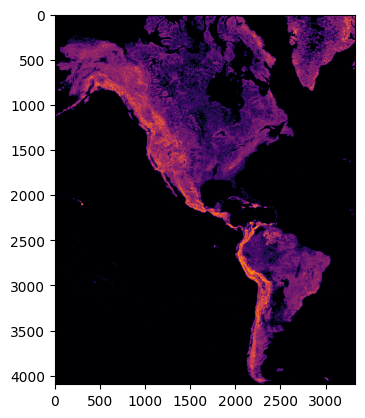

In [24]:
plt.imshow(world_map, cmap="inferno")
plt.show()